In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ml import KramersMoyal,load_kernels_dict
from plot import ImperialColors
from potenciala import BucketMethod, VectorTimeSeries


In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load multivariate time series for frequentist approach

In [5]:
s = VectorTimeSeries(df=df, 
                     signal_name="spain", 
                     bucket_method=BucketMethod.Round, 
                     bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

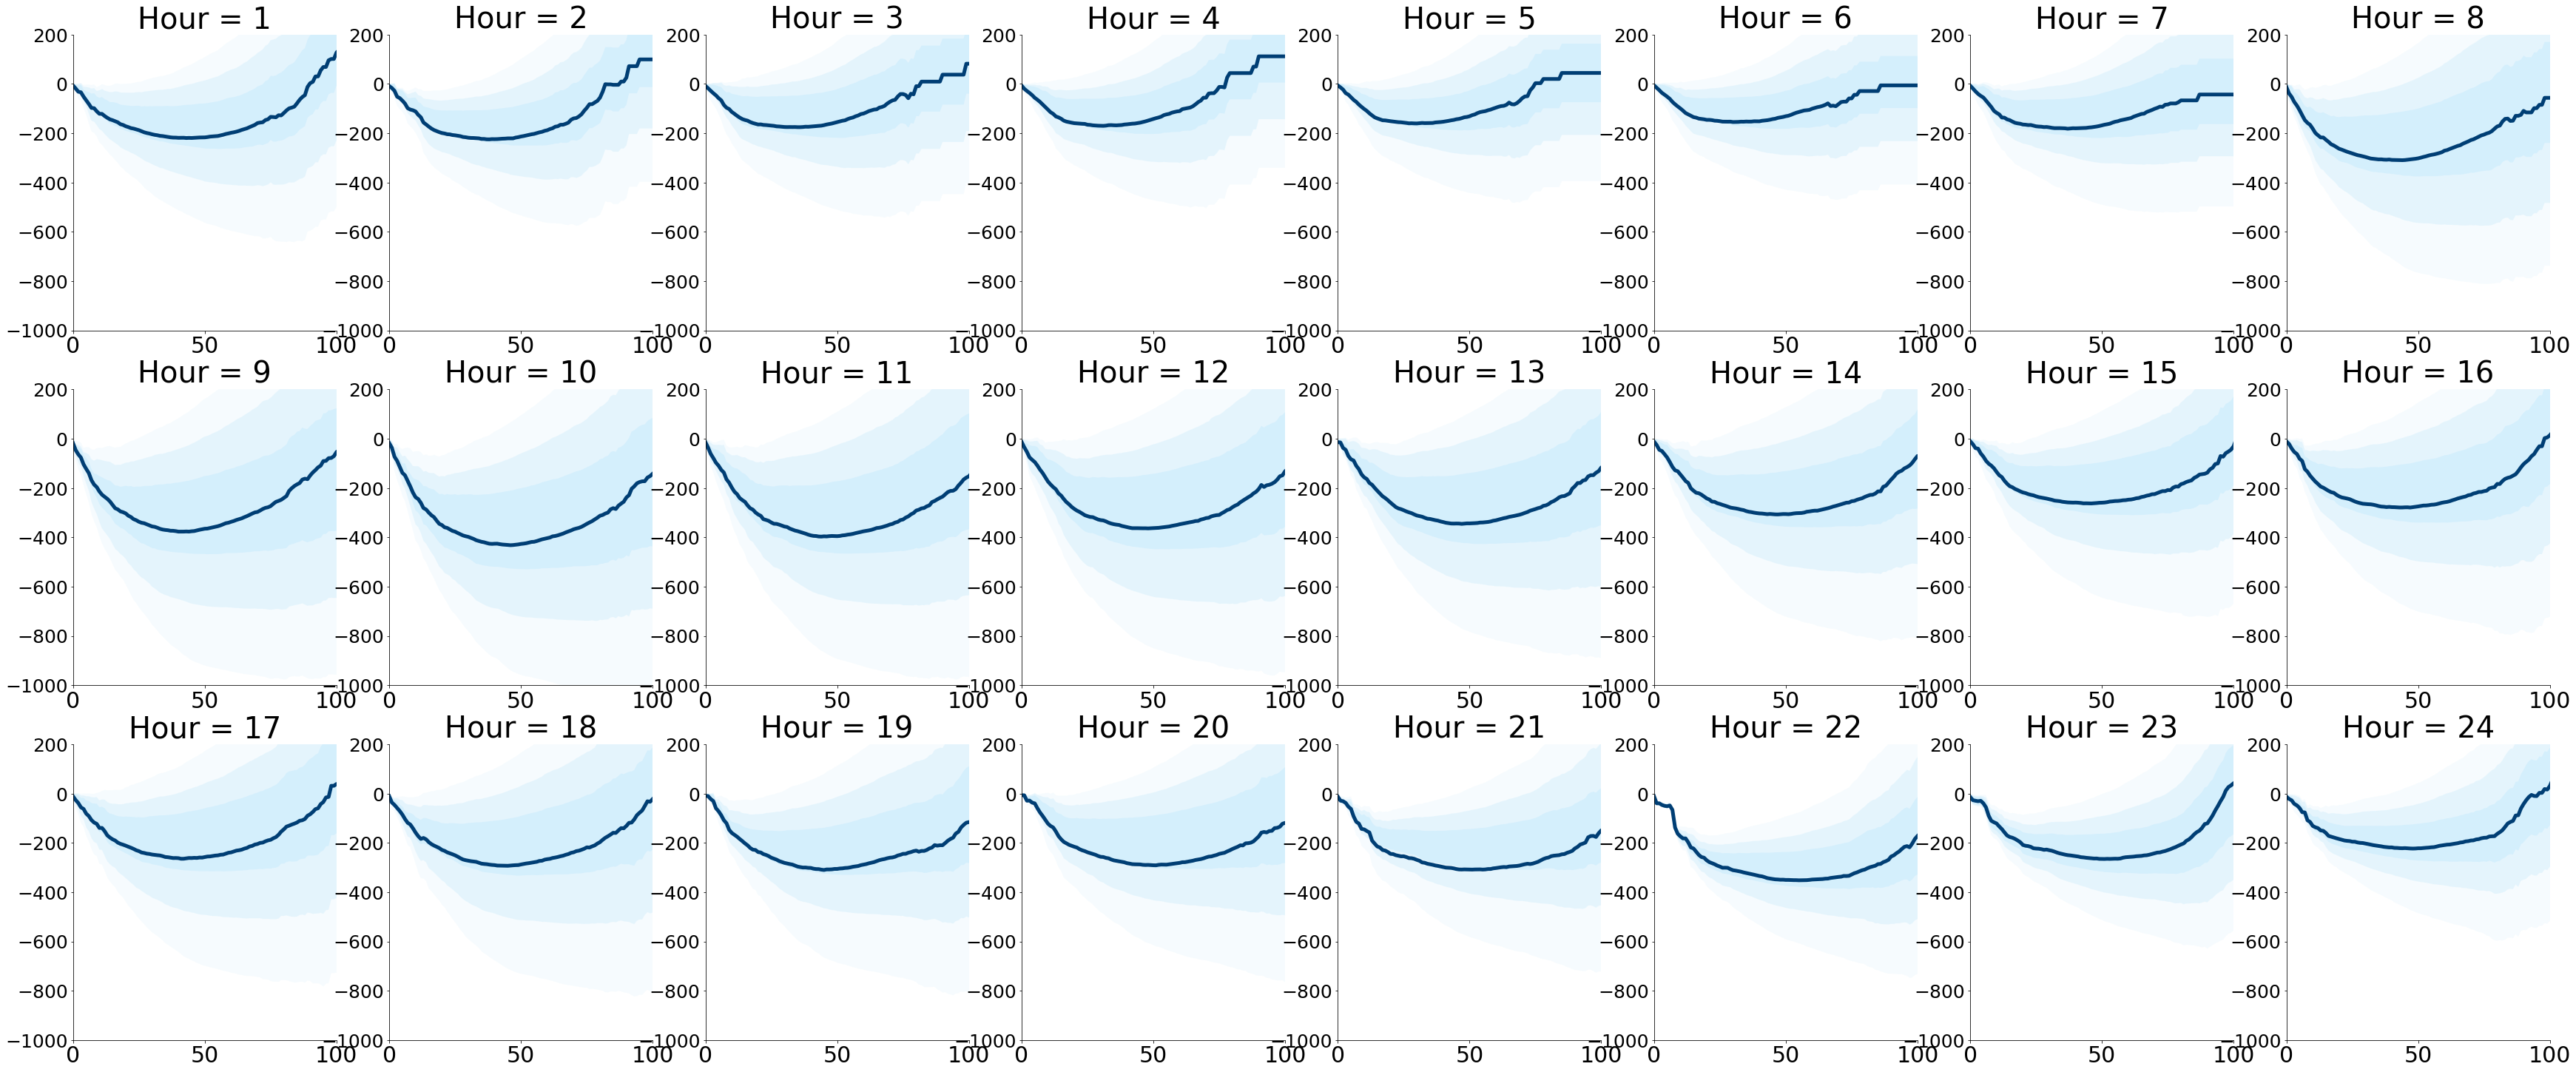

In [6]:
fig, axis = plt.subplots(3, 8, figsize=(60, 25))
percentiles_alpha = [0.2, 0.5, 1]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        s.potential_hour_x.loc[h].plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                    s.potential_percentile_hour_x.columns, 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[k]], 
                    s.potential_percentile_hour_x.loc[h, s.drift_quantile[-k-1]],
                    facecolor=ImperialColors.light_blue.value, alpha=alpha_value)
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 100)
        ax.set_ylim(-1000, 200)
        ax.tick_params(axis='x', labelsize=30)
        ax.tick_params(axis='y', labelsize=25)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

### Load multivariate series and KDE technique to compute drift and potential percentile

In [53]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)

In [54]:
x_range = d_1_dict[1].grid[0][:, 0]
perc_list = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]
hours_list = np.arange(1, 25)
multi_idx = pd.MultiIndex.from_product([hours_list, perc_list + ["mean"]])
drift_percentile_value_x = pd.DataFrame(index=multi_idx, columns=x_range)

for h in hours_list:
    gk = d_1_dict[h]
    for perc in perc_list:
        drift_percentile_value_x.loc[(h, perc), x_range] = np.zeros_like(x_range).astype(float)
        percentile_value = np.zeros_like(x_range)
        for i in range(x_range.shape[0]):
            first_index = np.where((np.cumsum(gk.p[i]) / sum(gk.p[i])) > perc)[0][0]
            percentile_value[i] = gk.grid[1][i][first_index]
        drift_percentile_value_x.loc[(h, perc)] = percentile_value.astype(float)

    drift_percentile_value_x.loc[(h,"mean")] = gk.expected_value_function[1, :]

# Integrate to compute potential
dx = gk.expected_value_function[0, 1] - gk.expected_value_function[0, 0]
potential_percentile_value_x = (-1)*np.cumsum(drift_percentile_value_x * dx, axis=1)

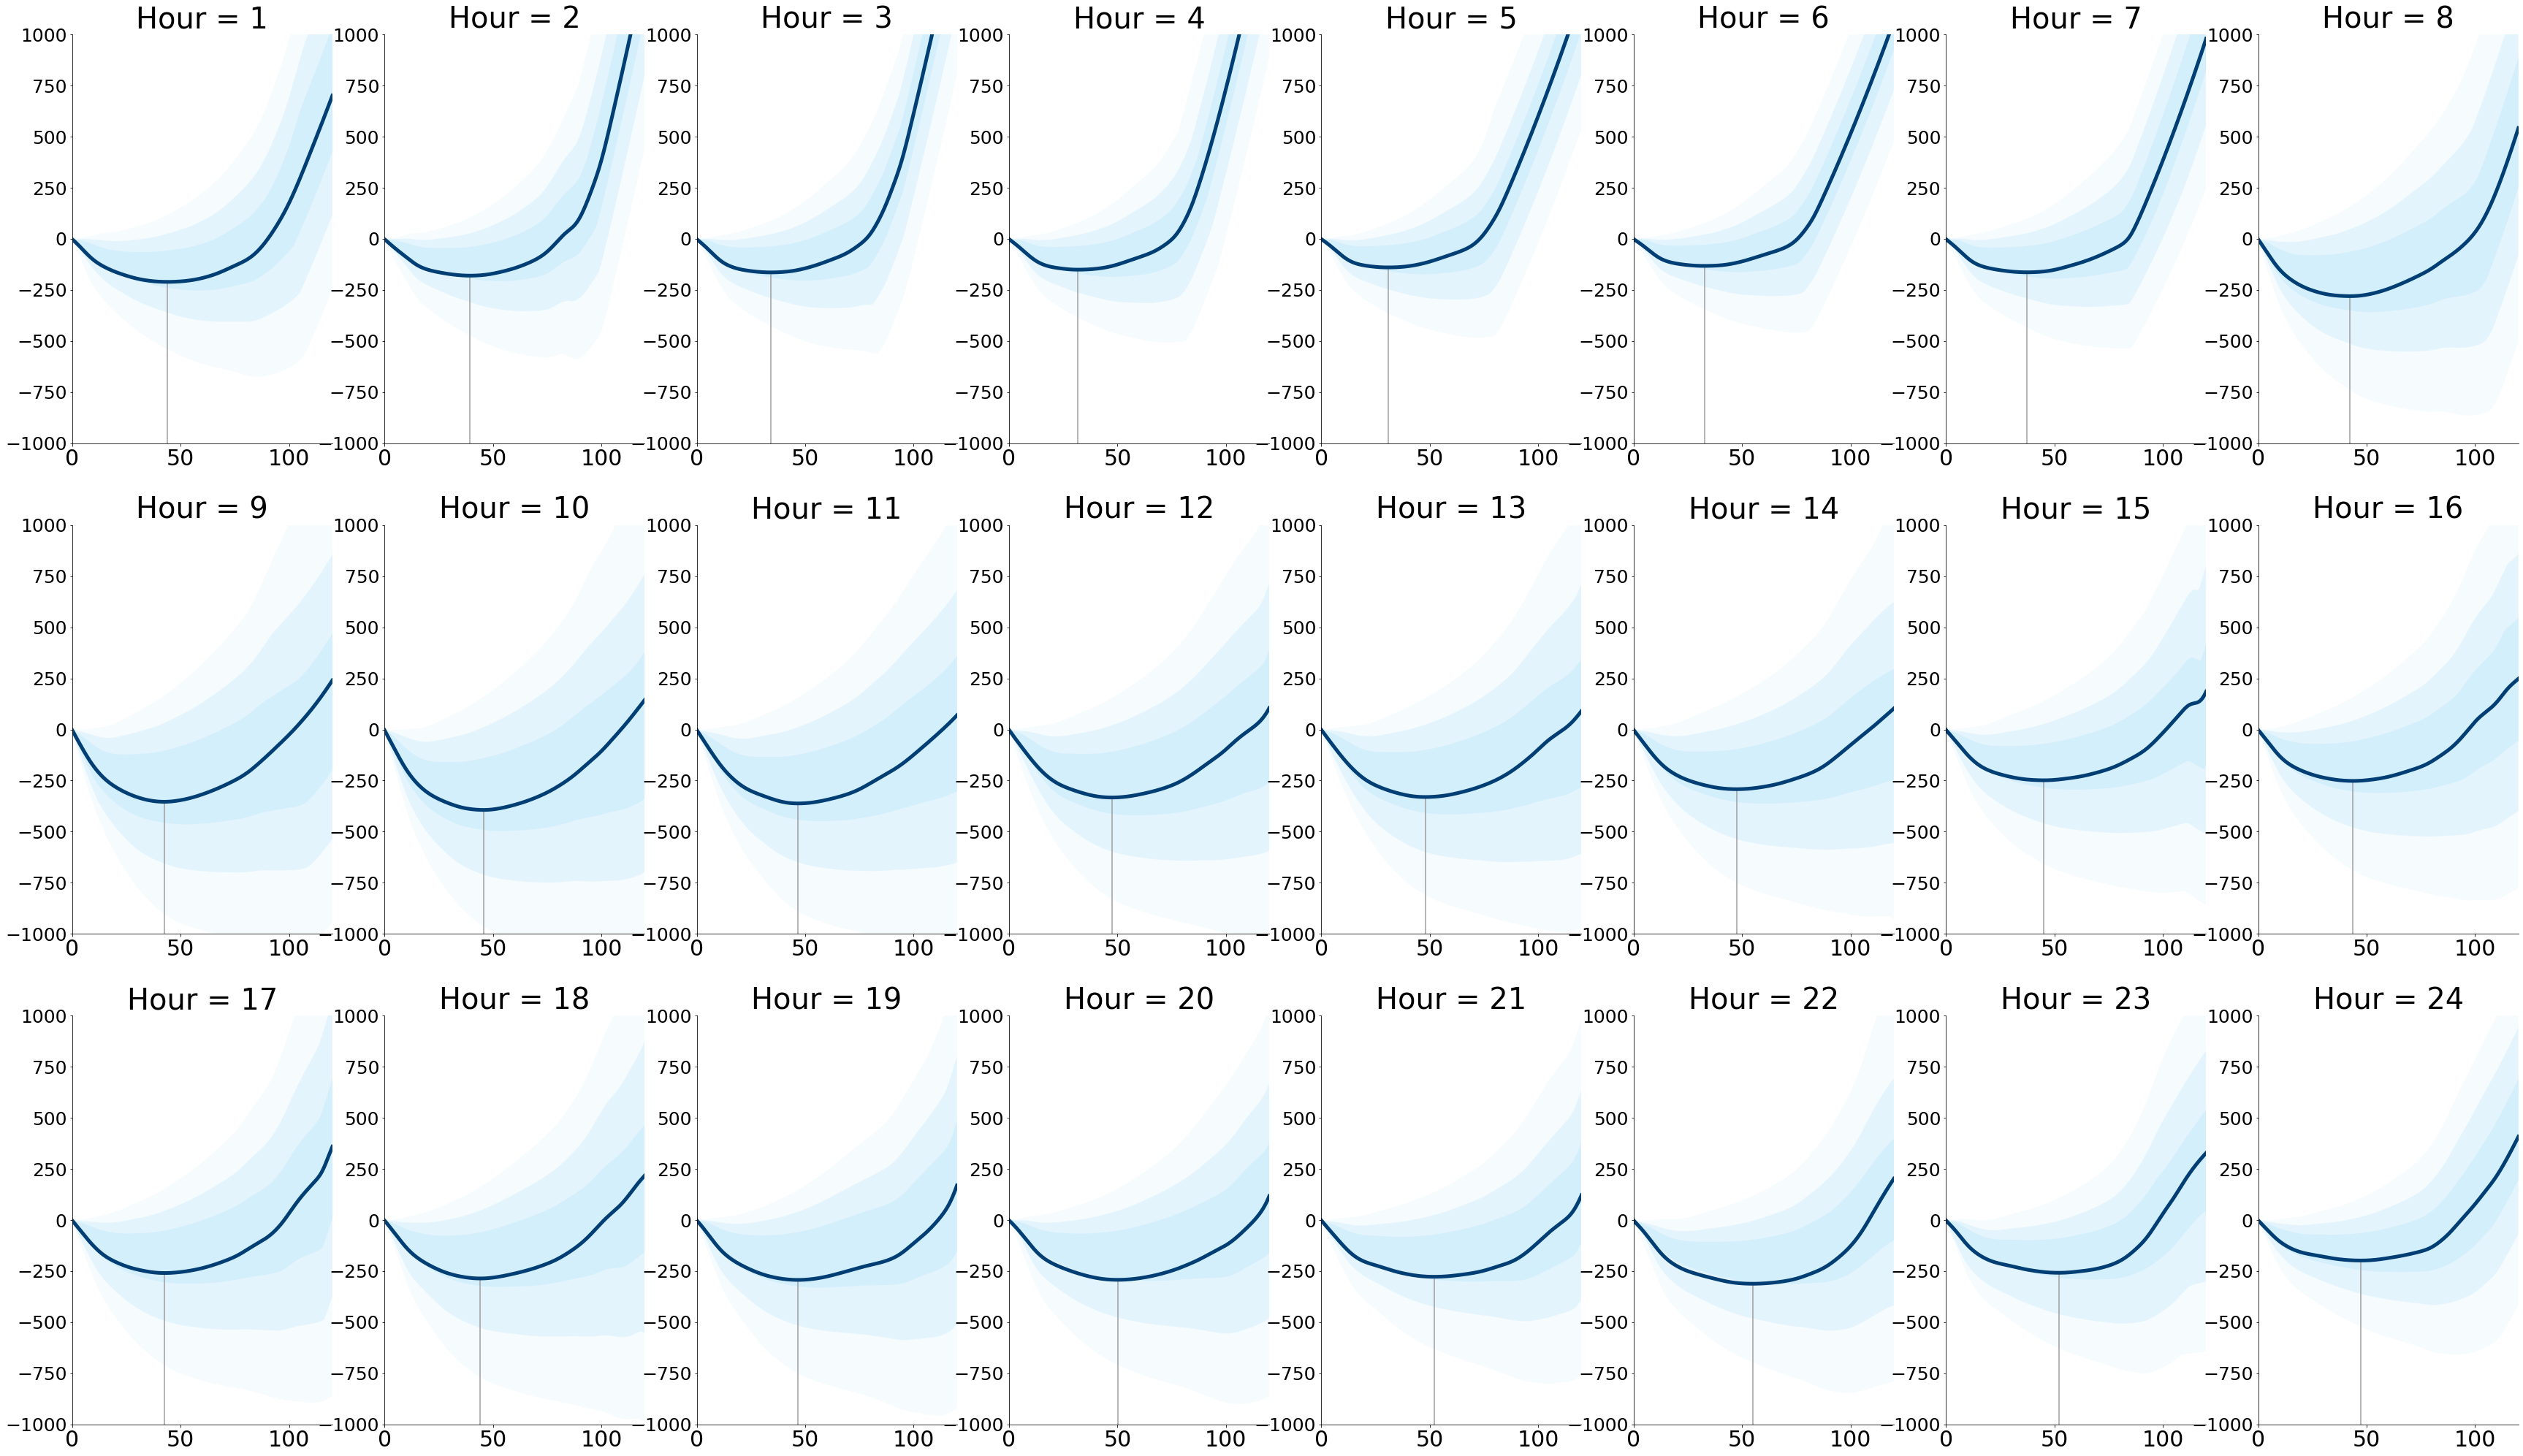

In [68]:
fig, axis = plt.subplots(3, 8, figsize=(60, 35))
percentiles_alpha = [0.2, 0.5, 1]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        potential_percentile_value_x.loc[h, "mean"].T.plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        for k, alpha_value in enumerate(percentiles_alpha):
            ax.fill_between(
                potential_percentile_value_x.columns, 
                potential_percentile_value_x.loc[h, perc_list[k]].astype(float), 
                potential_percentile_value_x.loc[h, perc_list[-k-1]].astype(float),
                facecolor=ImperialColors.light_blue.value, alpha=alpha_value)
            
        min_potential_index = potential_percentile_value_x.loc[h, "mean"].astype(float).argmin()
        x_min = potential_percentile_value_x.columns[min_potential_index]
        ax.vlines(
            x=x_min, ymin=-1_000, ymax=potential_percentile_value_x.loc[h, "mean"].iloc[min_potential_index],
            color=ImperialColors.cool_grey.value
        )
            
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 120)
        ax.set_ylim(-1000, 1000)
        ax.tick_params(axis='x', labelsize=30)
        ax.tick_params(axis='y', labelsize=25)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
            